# Defining Accelerator

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import sys
import cv2
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader, TensorDataset, Dataset
from skimage.util.shape import view_as_windows
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from google.colab.patches import cv2_imshow
from PIL import Image
from tqdm import tqdm

In [ ]:
cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
!mkdir checkpoint

mkdir: cannot create directory ‘checkpoint’: File exists


In [ ]:
cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
!mkdir best_checkpoint

# Getting Training Data

In [4]:
TRAIN_IMG_PATH = '/content/drive/My Drive/MoNuSeg-Training-Data/MoNuSeg-Training-Data/Norm-Tissue-Images/'
IMG_H, IMG_W = 1000, 1000

img_list = next(os.walk(TRAIN_IMG_PATH))[2]

total_imgs = 0
for img in img_list:
    total_imgs += 1

In [5]:
X_train = np.zeros((total_imgs, IMG_H, IMG_W, 3), dtype = np.uint8)
Y_train = np.zeros((total_imgs, IMG_H, IMG_W, 3), dtype = np.uint8)

print('Getting Training Data...')
sys.stdout.flush()

for n, img_name in tqdm(enumerate(img_list), total = total_imgs):
    
    img_path = TRAIN_IMG_PATH + img_name
    img = cv2.imread(img_path)[:, :, :3]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n] = img

    mask_path = '/content/drive/My Drive/MoNuSeg-Training-Data/MoNuSeg-Training-Data/Binary-Mask/' + img_name

    mask = cv2.imread(mask_path)
    Y_train[n] = mask

print('Done!')

Getting Training Data...


100%|██████████| 30/30 [00:36<00:00,  1.20s/it]

Done!


# Defining DataLoader Object

In [6]:
class Nuc_Aug(Dataset):
    
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        return image, mask
        
    def __len__(self):
        
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]

        image, mask = self.transform(image_np, mask_np)
        
        return image, mask

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)

train_dataset = Nuc_Aug(X_train, Y_train)
train_loader = DataLoader(train_dataset)

val_dataset = Nuc_Aug(X_val, Y_val)
val_loader = DataLoader(val_dataset)

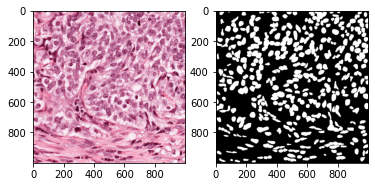

In [8]:
%matplotlib inline

# Sanity check of the training data

for ex_img, ex_mask in train_loader:
    
    img = np.array(TF.to_pil_image(ex_img[0]))
    mask = np.array(TF.to_pil_image(ex_mask[0]))
    
    fig, (axis_1, axis_2) = plt.subplots(1, 2)
    axis_1.imshow(img.astype(np.uint8))
    axis_2.imshow(mask.astype(np.uint8))
    
    break

# Defining Model Architechture

In [9]:
def conv_block_a(in_channels, out_channels, drop_rate, *args, **kwargs):

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.ReLU(),
        nn.Dropout2d(drop_rate),
        nn.MaxPool2d((2, 2), stride = 2)
    )

def conv_block_b(in_channels, out_channels, drop_rate, *args, **kwargs):

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.ReLU(),
        nn.Dropout2d(drop_rate),
        nn.MaxPool2d((2, 2), stride = 2, padding = 1)
    )

def fc_block(in_units, out_units, drop_rate, *args, **kwargs):

    return nn.Sequential(
        nn.Linear(in_units, out_units, *args, **kwargs),
        nn.ReLU(),
        nn.Dropout(drop_rate)
    )

In [10]:
class Patch_Seg(nn.Module):

    def __init__(self):

        super().__init__()
    
        self.conv_blocks = nn.Sequential(
            conv_block_a(3, 25, 0.1, kernel_size = (4, 4)),
            conv_block_a(25, 50, 0.2, kernel_size = (5, 5)),
            conv_block_b(50, 80, 0.25, kernel_size = (6, 6))
        )

        self.fc_blocks = nn.Sequential(
            fc_block(720, 1024, 0.5),
            fc_block(1024, 1024, 0.5)
        )

        self.final = nn.Linear(1024, 1)

    def forward(self, x):

        x = self.conv_blocks(x)

        x = x.view(-1, 720)
    
        x = self.fc_blocks(x)

        out = torch.sigmoid(self.final(x))

        return out

In [11]:
model = Patch_Seg()
model = model.float()
model = model.to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Patch_Seg(
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 25, kernel_size=(4, 4), stride=(1, 1))
      (1): ReLU()
      (2): Dropout2d(p=0.1, inplace=False)
      (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): Dropout2d(p=0.2, inplace=False)
      (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(50, 80, kernel_size=(6, 6), stride=(1, 1))
      (1): ReLU()
      (2): Dropout2d(p=0.25, inplace=False)
      (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (fc_blocks): Sequential(
    (0): Sequential(
      (0): Linear(in_features=720, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, o

# Data Augmentation Of Extracted Patches

In [12]:
class Patch_Aug(Dataset):
    
    def __init__(self, images_np):
        self.images_np = images_np
    
    def transform(self, image_np):
        
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)

        if random.random() > 0.5:
            image = TF.hflip(image)

        if random.random() > 0.5:
            image = TF.vflip(image)

        angle_list = [0, 90, 180, 270]
        angle_index = random.randint(0, 3)
        angle = angle_list[angle_index]
        image = TF.affine(image, scale = 1, angle = angle, translate = (0,0), shear = 0)
        
        image = TF.to_tensor(image)
        
        return image
        
    def __len__(self):
        
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]

        image = self.transform(image_np)
        
        return image

# Defining Loss Funciton & Optimizer

In [13]:
opt = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.BCELoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 5, verbose = 1)

# Model Training & Validation 

In [14]:
def fit(model, num_epochs, opt, lr_scheduler, loss_func, train_loader, val_loader, start_epoch, best_val_loss, best_val_acc, iteration_change_loss, patience):
    
    best_val_loss = best_val_loss
    best_val_acc = best_val_acc
    iteration_change_loss = iteration_change_loss
    patience = patience
    
    for epoch in range(start_epoch, num_epochs + 1):

        model.train()

        epoch_loss = 0
        epoch_correct = 0

        # Training the model
        for image, mask in train_loader:

            X = np.array(TF.to_pil_image(image[0]))
            Y = np.array(TF.to_pil_image(mask[0]))

            train_loss = 0
            correct = 0

            img = TF.to_pil_image(X)
            img = TF.pad(img, padding = 25, padding_mode = 'reflect')  # To extract patches with boundary pixels as centers 
            img = np.array(img)

            img_windows = view_as_windows(img, (51, 51, 3))  # Patch Extraction  

            # Training 9600 patches per image
            for j in range(75):
                
                opt.zero_grad()
                loss = 0

                for k in range(128):

                    # Getting random patches
                    idx_1 = random.randint(0, 999)
                    idx_2 = random.randint(0, 999)
      
                    patch_img = img_windows[idx_1, idx_2]
                    
                    # Data augmentation of the patch
                    patch_aug = Patch_Aug(patch_img)
                    patch_img_aug = patch_aug.__getitem__(0)

                    # Passing patch to GPU
                    patch_img_aug = patch_img_aug.to(device)
                    patch_img_aug = patch_img_aug.unsqueeze(0)

                    # Assigning ground truth label based on label of center pixel of patch
                    patch_label = torch.zeros((1, 1), dtype = np.bool)
                    patch_label = patch_label.to(device)

                    if Y[idx_1][idx_2][0] == 255:
                        patch_label[0][0] = 1

                    else:
                        patch_label[0][0] = 0

                    out = model(patch_img_aug.float())
                    
                    # Thresholding the sigmoid output
                    if out[0][0] > 0.5:
                        out_pred = 1

                    else:
                        out_pred = 0 
                    
                    # To quantify accuracy
                    if out_pred == patch_label[0][0]:
                        correct += 1
                    
                    loss += loss_func(out.float(), patch_label.float()) 

                    del patch_img, patch_label

                loss = loss/float(128)
                train_loss += loss

                loss.backward()
                opt.step()

            del img_windows # To free up memory

            epoch_loss += train_loss
            epoch_correct += correct

            print("Epoch: ", epoch, "| Training Loss in Image: ", train_loss/float(75), "| Accuracy: ", correct/float(75*128))
            sys.stdout.flush()

        
        model.eval()

        with torch.no_grad():
        
            epoch_valid_loss = 0
            epoch_valid_correct = 0

            # Evaluating the model each epoch
            for image, mask in val_loader:

                X = np.array(TF.to_pil_image(image[0]))
                Y = np.array(TF.to_pil_image(mask[0]))

                valid_loss = 0
                correct = 0

                img = TF.to_pil_image(X)
                img = TF.pad(img, padding = 25, padding_mode = 'reflect')  # To extract patches with boundary pixels as centers
                img = np.array(img)

                img_windows = view_as_windows(img, (51, 51, 3))  # Patch Extraction
            
                # Validating 7500 patches per image
                for j in range(150):
                
                    for k in range(50):

                        # Getting random patches
                        idx_1 = random.randint(0, 999)
                        idx_2 = random.randint(0, 999)
      
                        patch_img = img_windows[idx_1, idx_2]
                        patch_img = TF.to_tensor(TF.to_pil_image(patch_img[0]))
                        patch_img = patch_img.unsqueeze(0)
                        patch_img = patch_img.to(device)

                        # Assigning ground truth label based on label of center pixel of patch
                        patch_label = torch.zeros((1, 1), dtype = np.bool)
                        patch_label = patch_label.to(device)

                        if Y[idx_1][idx_2][0] == 255:
                            patch_label[0][0] = 1

                        else:
                            patch_label[0][0] = 0

                        out = model(patch_img.float())

                        # Thresholding the sigmoid output
                        if out[0][0] > 0.5:
                            out_pred = 1

                        else:
                            out_pred = 0 
                    
                        # To quantify accuracy
                        if out_pred == patch_label[0][0]:
                            correct += 1
                    
                        loss = loss_func(out.float(), patch_label.float())
                        valid_loss += loss

                        del patch_img, patch_label

                del img_windows  # To free up memory

                epoch_valid_loss += valid_loss
                epoch_valid_correct += correct

            
            # To track progress in mask generation every 10 epochs by observing image
            if epoch % 10 == 0:
                
                pred_img = torch.zeros((1000, 1000))

                for image, mask in val_loader:

                    X = np.array(TF.to_pil_image(image[0]))
                    Y = np.array(TF.to_pil_image(mask[0]))

                    correct = 0

                    img = TF.to_pil_image(X)
                    img = TF.pad(img, padding = 25, padding_mode = 'reflect')  # To extract patches with boundary pixels as centers
                    img = np.array(img)

                    img_windows = view_as_windows(img, (51, 51, 3))  # Patch Extraction
            
                    # Getting predictions for all pixels in one 1000x1000 image from validation set
                    for j in range(1000):
                
                        for k in range(1000):
      
                            patch_img = img_windows[j, k]
                            patch_img = TF.to_tensor(TF.to_pil_image(patch_img[0]))
                            patch_img = patch_img.unsqueeze(0)
                            patch_img = patch_img.to(device)

                            # Assigning ground truth label based on label of center pixel of patch
                            patch_label = torch.zeros((1, 1), dtype = np.bool)
                            patch_label = patch_label.to(device)

                            if Y[j][k][0] == 255:
                                patch_label[0][0] = 1

                            else:
                                patch_label[0][0] = 0

                            out = model(patch_img.float())

                            # Thresholding the sigmoid output
                            if out[0][0] > 0.5:
                                out_pred = 1

                            else:
                                out_pred = 0 

                            pred_img[j][k] = out_pred

                            # To quantify accuracy
                            if out_pred == patch_label[0][0]:
                                correct += 1

                            del patch_img, patch_label

                    del img_windows # To free up memory

                    print('Accuracy on val image: ', correct/float(1000*1000))

                    pred_np = np.array(TF.to_pil_image(pred_img))
                    mask_np = np.array(TF.to_pil_image(mask[0]))
                    
                    # Displaying the mask generated to track progress
                    fig, (axis_1, axis_2) = plt.subplots(1, 2)
                    axis_1.imshow(pred_np.astype(np.uint8), cmap = 'gray')
                    axis_2.imshow(mask_np.astype(np.uint8))
                    plt.show()

                    break    

        ovr_train_loss = epoch_loss/float(24*75)
        ovr_train_acc = epoch_correct/float(24*75*128) 
        ovr_val_loss =  epoch_valid_loss/float(6*50*150)
        ovr_val_acc =  epoch_valid_correct/float(6*50*150)

        print("Epoch: ", epoch, "| Epoch Loss: ", ovr_train_loss, "| Epoch Accuracy: ", ovr_train_acc)
        print("Epoch Valid Loss: ", ovr_val_loss, "| Epoch Valid Accuracy: ", ovr_val_acc)
        sys.stdout.flush()

        # Reducing learning rate if validaiton loss stalls for 5 epochs
        lr_scheduler.step(ovr_val_loss)

        iteration_change_loss += 1
        print('-' * 30)

        if ovr_val_loss < best_val_loss:
            best_val_loss = ovr_val_loss
            iteration_change_loss = 0

        # Saving the model & other relevant states after each epoch to resume training
        state = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'opt_state_dict': opt.state_dict(),
        'lr_state_dict': lr_scheduler.state_dict(),
        'loss': ovr_train_loss,
        'accuracy': ovr_train_acc,
        'best_val_loss': best_val_loss, 
        'best_val_acc': best_val_acc, 
        'iteration_change_loss': iteration_change_loss, 
        'patience': patience
        }

        torch.save(state, '/content/drive/My Drive/monuseg_checkpoint/new_current_checkpoint.pt')

        # Saving the model achieving best validation accuracy for inference later
        if ovr_val_acc > best_val_acc:
            best_val_acc = ovr_val_acc

            print('Saving best model...')
            sys.stdout.flush()

            torch.save(model.state_dict(), '/content/drive/My Drive/best_checkpoint/best_current_checkpoint.pt')

        # Stopping model training if no improvement in validation accuracy for 15 epochs
        if iteration_change_loss == patience:
            print('Early stopping after {0} iterations without the decrease of the val loss'.format(iteration_change_loss))
            sys.stdout.flush()

            break

Epoch:  0  Training Loss in Image:  tensor(0.5091, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.750625
Epoch:  0  Training Loss in Image:  tensor(0.4284, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.8007291666666667
Epoch:  0  Training Loss in Image:  tensor(0.2982, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.8742708333333333
Epoch:  0  Training Loss in Image:  tensor(0.2275, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.9044791666666666
Epoch:  0  Training Loss in Image:  tensor(0.2588, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.8827083333333333
Epoch:  0  Training Loss in Image:  tensor(0.1534, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.936875
Epoch:  0  Training Loss in Image:  tensor(0.1882, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.9267708333333333
Epoch:  0  Training Loss in Image:  tensor(0.3279, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.8580208333333333
Epoch:  0  Training Loss in Image:  

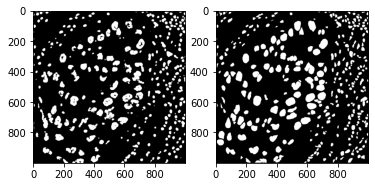

Epoch:  0  Epoch Loss:  tensor(0.2912, device='cuda:0', grad_fn=<DivBackward0>)  Epoch Accuracy:  0.8721527777777778
Epoch Valid Loss:  tensor(0.2557, device='cuda:0')  Epoch Valid Accuracy:  0.8942666666666667
------------------------------
Saving best model...
Epoch:  1  Training Loss in Image:  tensor(0.3501, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.8523958333333334
Epoch:  1  Training Loss in Image:  tensor(0.3604, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.8365625
Epoch:  1  Training Loss in Image:  tensor(0.2597, device='cuda:0', grad_fn=<DivBackward0>)  Accuracy:  0.886875


In [ ]:
fit(model, 100, opt, lr_scheduler, loss_func, train_loader, val_loader, 0, float('inf'), float(0), 0, 15)

# Resuming Model Training 

In [15]:
model = Patch_Seg()
model = model.float()
model = model.to(device)

opt = optim.Adam(model.parameters(), lr = 0.01)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 5, verbose = 1)

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/monuseg_checkpoint/new_current_checkpoint.pt')
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['opt_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_state_dict'])
loss = checkpoint['loss']
accuracy = checkpoint['accuracy']
best_val_loss = checkpoint['best_val_loss'] 
best_val_acc = checkpoint['best_val_acc']
iteration_change_loss = checkpoint['iteration_change_loss']
patience = checkpoint['patience']

print("Epoch: ", start_epoch - 1, "| Epoch Loss: ", loss, "| Epoch Accuracy: ", accuracy)
sys.stdout.flush()

Epoch:  41 | Epoch Loss:  tensor(0.2669, device='cuda:0', requires_grad=True) | Epoch Accuracy:  0.8857118055555555


Epoch:  34 | Training Loss in Image:  tensor(0.3269, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.8585416666666666
Epoch:  34 | Training Loss in Image:  tensor(0.3257, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.855
Epoch:  34 | Training Loss in Image:  tensor(0.2313, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.9023958333333333
Epoch:  34 | Training Loss in Image:  tensor(0.1640, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.9319791666666667
Epoch:  34 | Training Loss in Image:  tensor(0.2828, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.87875
Epoch:  34 | Training Loss in Image:  tensor(0.1402, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.9420833333333334
Epoch:  34 | Training Loss in Image:  tensor(0.1537, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.9408333333333333
Epoch:  34 | Training Loss in Image:  tensor(0.3196, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.8570833333333333
Epoch:  34 | Tra

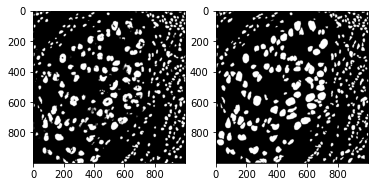

Epoch:  40 | Epoch Loss:  tensor(0.2679, device='cuda:0', grad_fn=<DivBackward0>) | Epoch Accuracy:  0.8857421875
Epoch Valid Loss:  tensor(0.2119, device='cuda:0') | Epoch Valid Accuracy:  0.9095555555555556
------------------------------
Epoch:  41 | Training Loss in Image:  tensor(0.3479, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.8536458333333333
Epoch:  41 | Training Loss in Image:  tensor(0.3282, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.85375
Epoch:  41 | Training Loss in Image:  tensor(0.2255, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.903125
Epoch:  41 | Training Loss in Image:  tensor(0.1666, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.9297916666666667
Epoch:  41 | Training Loss in Image:  tensor(0.2863, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.8777083333333333
Epoch:  41 | Training Loss in Image:  tensor(0.1457, device='cuda:0', grad_fn=<DivBackward0>) | Accuracy:  0.9436458333333333
Epoch:  41 | Training Los

In [ ]:
fit(model, 100, opt, lr_scheduler, loss_func, train_loader, val_loader, start_epoch, best_val_loss, best_val_acc, iteration_change_loss, patience)

# Loading Best Model For Inference

In [16]:
best_checkpoint = torch.load('/content/drive/My Drive/best_checkpoint/best_current_checkpoint.pt')
model.load_state_dict(best_checkpoint)

<All keys matched successfully>

# Post-Processing Operations 

In [17]:
def noise_filter(pred_img, iterations):

    for n in range(iterations):    
        
        for i in range(1000):
            
            for j in range(1000):

                count_zero = 0
                count_one = 0

                try:
                    if pred_img[i][j-1] == 0:
                        count_zero += 1

                except:
                    pass

                try:
                    if pred_img[i][j+1] == 0:
                        count_zero += 1

                except:
                    pass

                try:
                    if pred_img[i-1][j] == 0:
                        count_zero += 1

                except:
                    pass

                try:
                    if pred_img[i+1][j] == 0:
                        count_zero += 1

                except:
                    pass

                try:
                    if pred_img[i][j-1] == 1:
                        count_one += 1

                except:
                    pass

                try:
                    if pred_img[i][j+1] == 1:
                        count_one += 1

                except:
                    pass

                try:
                    if pred_img[i-1][j] == 1:
                        count_one += 1

                except:
                    pass

                try:
                    if pred_img[i+1][j] == 1:
                        count_one += 1

                except:
                    pass

                if count_zero >= 3:
                    pred_img[i][j] = 0

                if count_one >= 3:
                    pred_img[i][j] = 1

    return pred_img

# Results & Mean Jaccard Index Post Noise Removal

Accuracy on val image:  0.9325
Jaccard Index:  0.6993641453924266


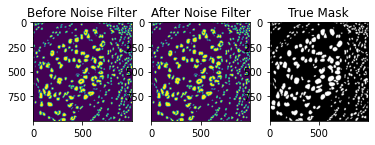

True Image


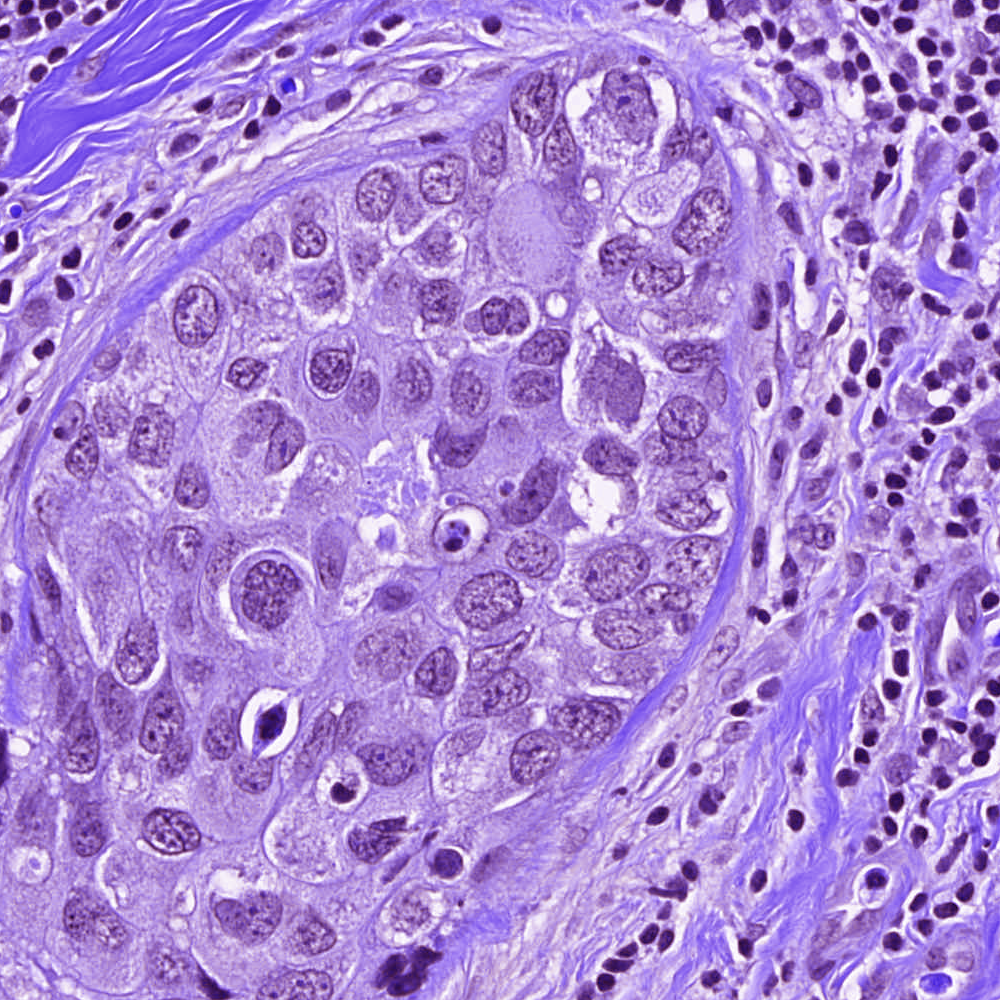



After Noise Filter


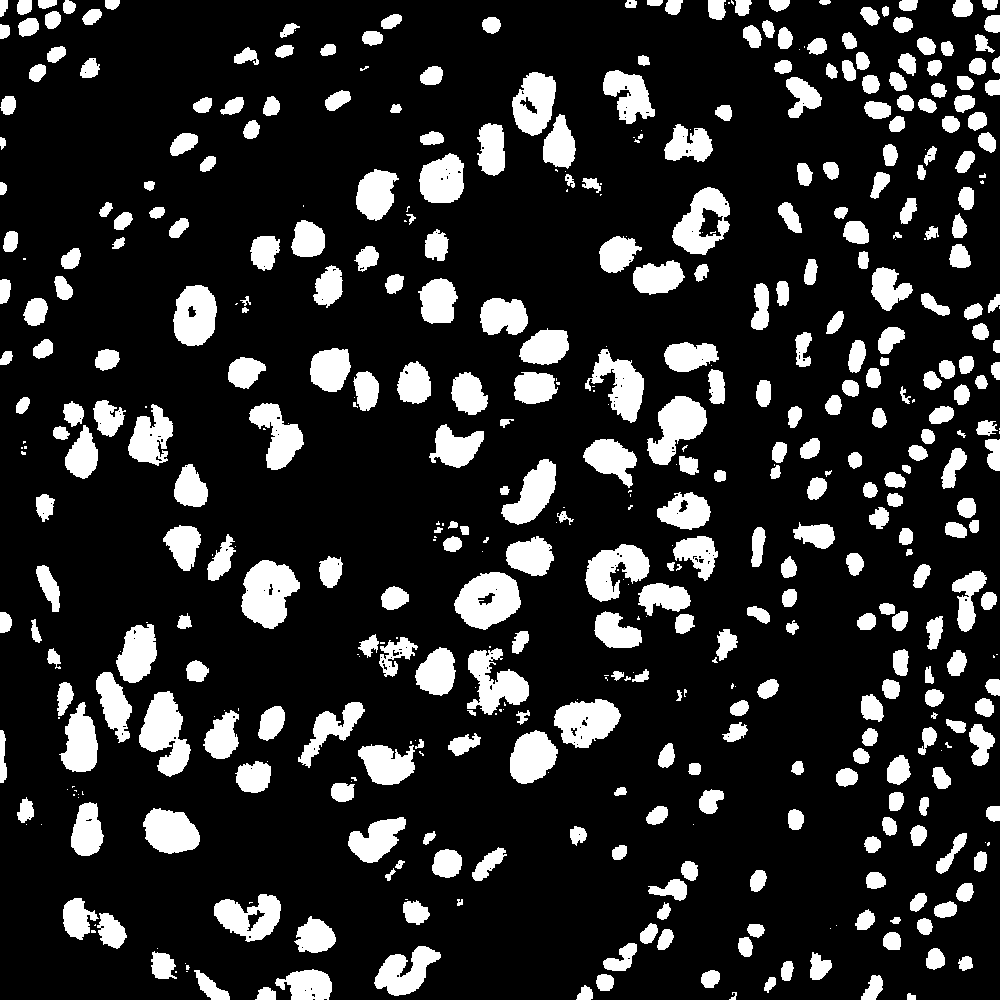



True Mask


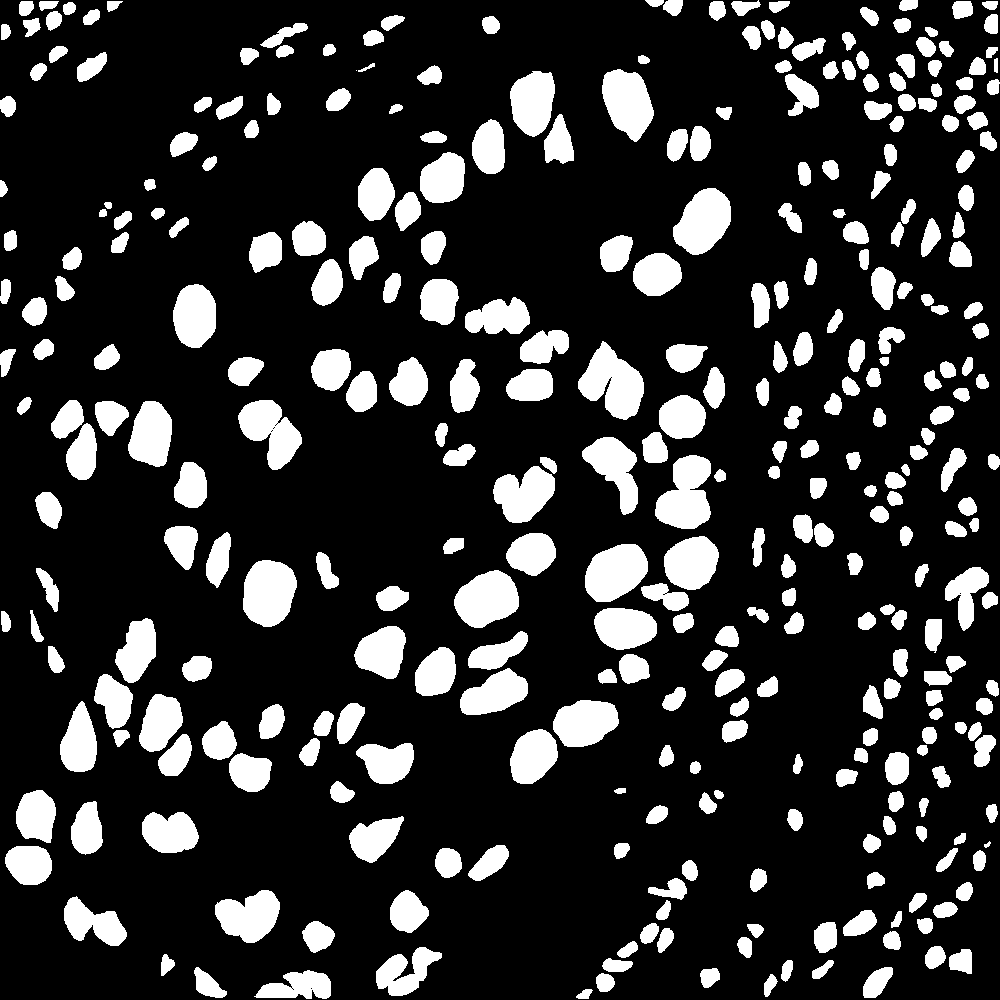

In [ ]:
jac_index = 0

for image, mask in val_loader:
    
    pred_img = torch.zeros((1000, 1000))
    true_img = torch.zeros((3, 1000, 1000))

    true_img = mask[0]

    X = np.array(TF.to_pil_image(image[0]))
    Y = np.array(TF.to_pil_image(mask[0]))

    correct = 0

    img = TF.to_pil_image(X)
    img = TF.pad(img, padding = 25, padding_mode = 'reflect')
    img = np.array(img)

    img_windows = view_as_windows(img, (51, 51, 3))
            
    for j in range(1000):
                
        for k in range(1000):
      
            patch_img = img_windows[j, k]
            patch_img = TF.to_tensor(TF.to_pil_image(patch_img[0]))
            patch_img = patch_img.unsqueeze(0)
            patch_img = patch_img.to(device)

            patch_label = torch.zeros((1, 1), dtype = np.bool)
            patch_label = patch_label.to(device)

            if Y[j][k][0] == 255:
                patch_label[0][0] = 1

            else:
                patch_label[0][0] = 0

            out = model(patch_img.float())

            if out[0][0] > 0.5:
                out_pred = 1

            else:
                out_pred = 0 
                    
            pred_img[j][k] = out_pred
                    
            if out_pred == patch_label[0][0]:
                correct += 1

            del patch_img, patch_label

    del img_windows

    print('Accuracy on val image: ', correct/float(1000*1000))

    true_np = np.array(TF.to_pil_image(true_img))
    true_gray = cv2.cvtColor(true_np, cv2.COLOR_BGR2GRAY)
    true_tensor = TF.to_tensor(TF.to_pil_image(true_gray))
    true_mask = true_tensor[0]

    pred_modified = noise_filter(pred_img, 1)

    pred_flat = pred_modified.view(-1)
    true_flat = true_mask.view(-1)
    score = jaccard_score(pred_flat, true_flat)
    print("Jaccard Index: ", score)

    jac_index += score

    pred_orig_np = np.array(TF.to_pil_image(pred_img)) 
    pred_np = np.array(TF.to_pil_image(pred_modified))
    true_np = np.array(TF.to_pil_image(true_img))

    fig, (axis_1, axis_2, axis_3) = plt.subplots(1, 3)
    axis_1.imshow(pred_orig_np.astype(np.uint8))
    axis_1.set_title("Before Noise Filter")
    axis_2.imshow(pred_np.astype(np.uint8))
    axis_2.set_title("After Noise Filter")
    axis_3.imshow(true_np.astype(np.uint8))
    axis_3.set_title("True Mask")
    plt.show()
    
    print("True Image")
    cv2_imshow(X)
    print("\n")
    print("After Noise Filter")
    cv2_imshow(pred_np)
    print("\n")
    print("True Mask")
    cv2_imshow(true_np)
    print("\n")

print("Average Jaccard Index over validation set: ", jac_index/len(val_loader))

Accuracy on val image:  0.932389


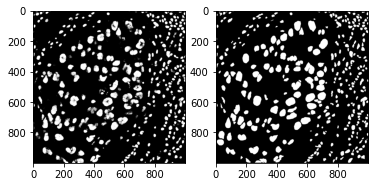

In [19]:
# Modifying and testing on one val image

pred_img = torch.zeros((1000, 1000))
true_img = torch.zeros((3, 1000, 1000))

for image, mask in val_loader:

    true_img = mask[0]

    X = np.array(TF.to_pil_image(image[0]))
    Y = np.array(TF.to_pil_image(mask[0]))

    correct = 0

    img = TF.to_pil_image(X)
    img = TF.pad(img, padding = 25, padding_mode = 'reflect')
    img = np.array(img)

    img_windows = view_as_windows(img, (51, 51, 3))
            
    for j in range(1000):
                
        for k in range(1000):
      
            patch_img = img_windows[j, k]
            patch_img = TF.to_tensor(TF.to_pil_image(patch_img[0]))
            patch_img = patch_img.unsqueeze(0)
            patch_img = patch_img.to(device)

            patch_label = torch.zeros((1, 1), dtype = np.bool)
            patch_label = patch_label.to(device)

            if Y[j][k][0] == 255:
                patch_label[0][0] = 1

            else:
                patch_label[0][0] = 0

            out = model(patch_img.float())

            if out[0][0] > 0.5:
                out_pred = 1

            else:
                out_pred = 0 
                    
            pred_img[j][k] = out_pred
                    
            if out_pred == patch_label[0][0]:
                correct += 1

            del patch_img, patch_label

    del img_windows

    print('Accuracy on val image: ', correct/float(1000*1000))

    pred_np = np.array(TF.to_pil_image(pred_img))
    mask_np = np.array(TF.to_pil_image(mask[0]))

    fig, (axis_1, axis_2) = plt.subplots(1, 2)
    axis_1.imshow(pred_np.astype(np.uint8), cmap = 'gray')
    axis_2.imshow(mask_np.astype(np.uint8))
    plt.show()

    break

In [20]:
true_alt = true_img

true_np = np.array(TF.to_pil_image(true_alt))
true_gray = cv2.cvtColor(true_np, cv2.COLOR_BGR2GRAY)
true_tensor = TF.to_tensor(TF.to_pil_image(true_gray))

true_mask = true_tensor[0]

print(pred_img.shape)
print(true_mask.shape)

torch.Size([1000, 1000])
torch.Size([1000, 1000])


In [21]:
pred_flat = pred_img.view(-1)
true_flat = true_mask.view(-1)
score = jaccard_score(pred_flat, true_flat)
print(score)

0.6822537514745068


Jaccard Index:  0.6985208741107947
After Noise Filtering


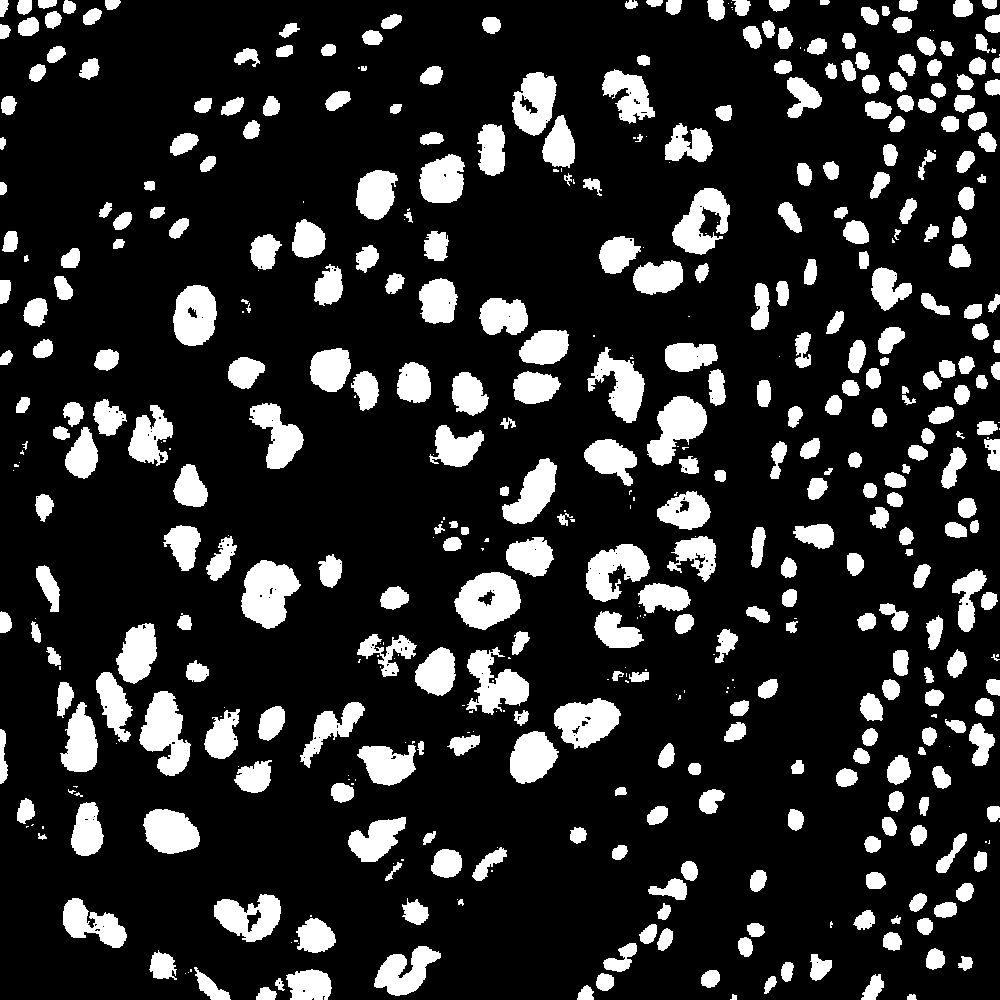


 True Mask


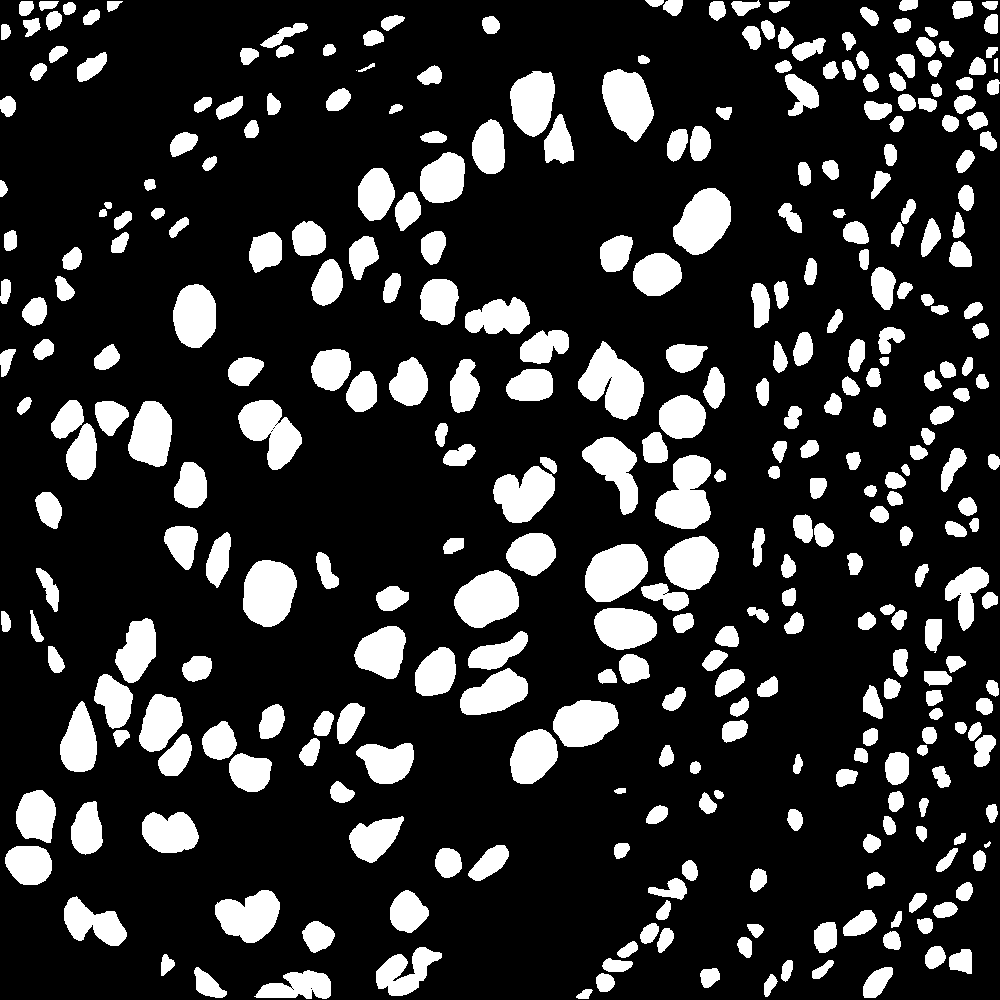

In [22]:
pred_modified = noise_filter(pred_img, 1)

pred_flat = pred_modified.view(-1)
true_flat = true_mask.view(-1)
score = jaccard_score(pred_flat, true_flat)
print("Jaccard Index: ", score)

pred_np = np.array(TF.to_pil_image(pred_modified))
true_np = np.array(TF.to_pil_image(true_mask))

print("After Noise Filtering")
cv2_imshow(pred_np)
print("\n True Mask")
cv2_imshow(true_np)

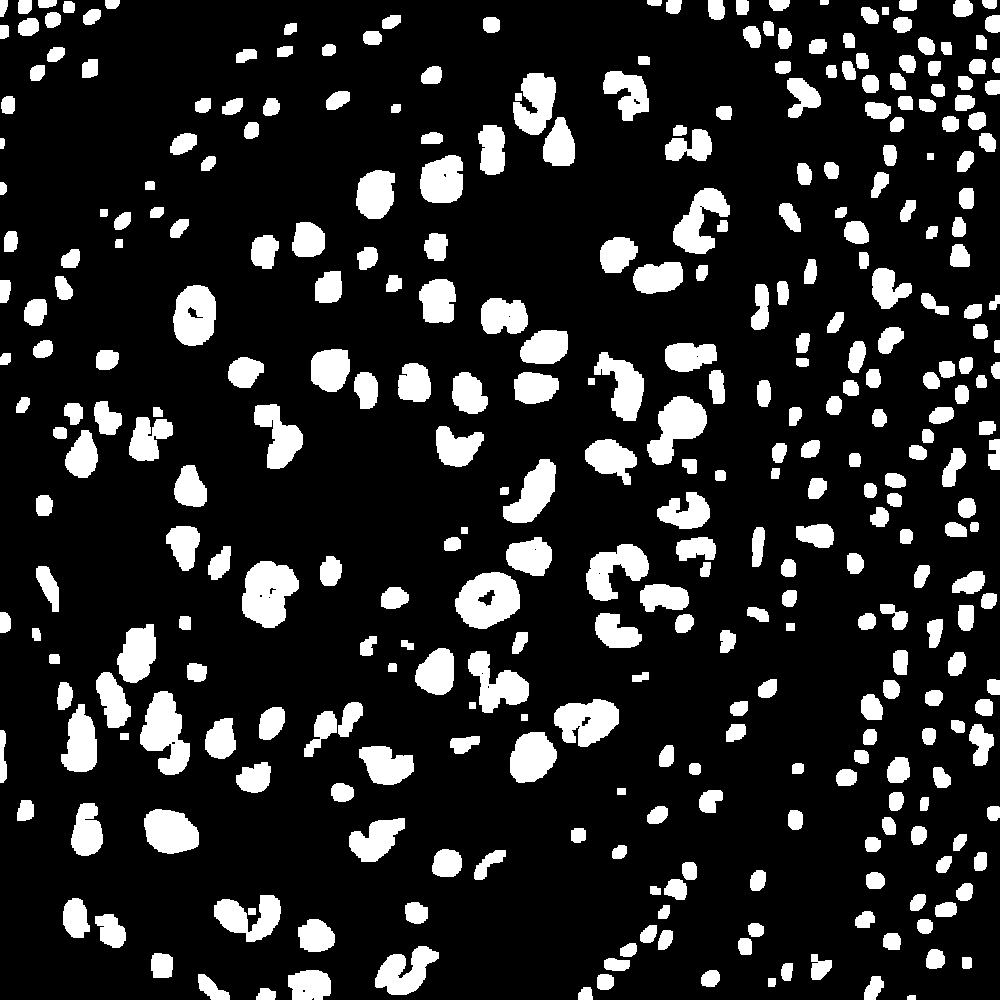

Jaccard Index:  0.6803751032505709


In [25]:
pred_mod_alias_np = np.array(TF.to_pil_image(pred_modified))

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(pred_mod_alias_np, cv2.MORPH_OPEN, kernel, iterations = 3)

cv2_imshow(opening)
opening_ten = TF.to_tensor(TF.to_pil_image(opening))

opening_flat = opening_ten.view(-1)
true_flat = true_mask.view(-1)
score = jaccard_score(opening_flat, true_flat)
print("Jaccard Index: ", score)

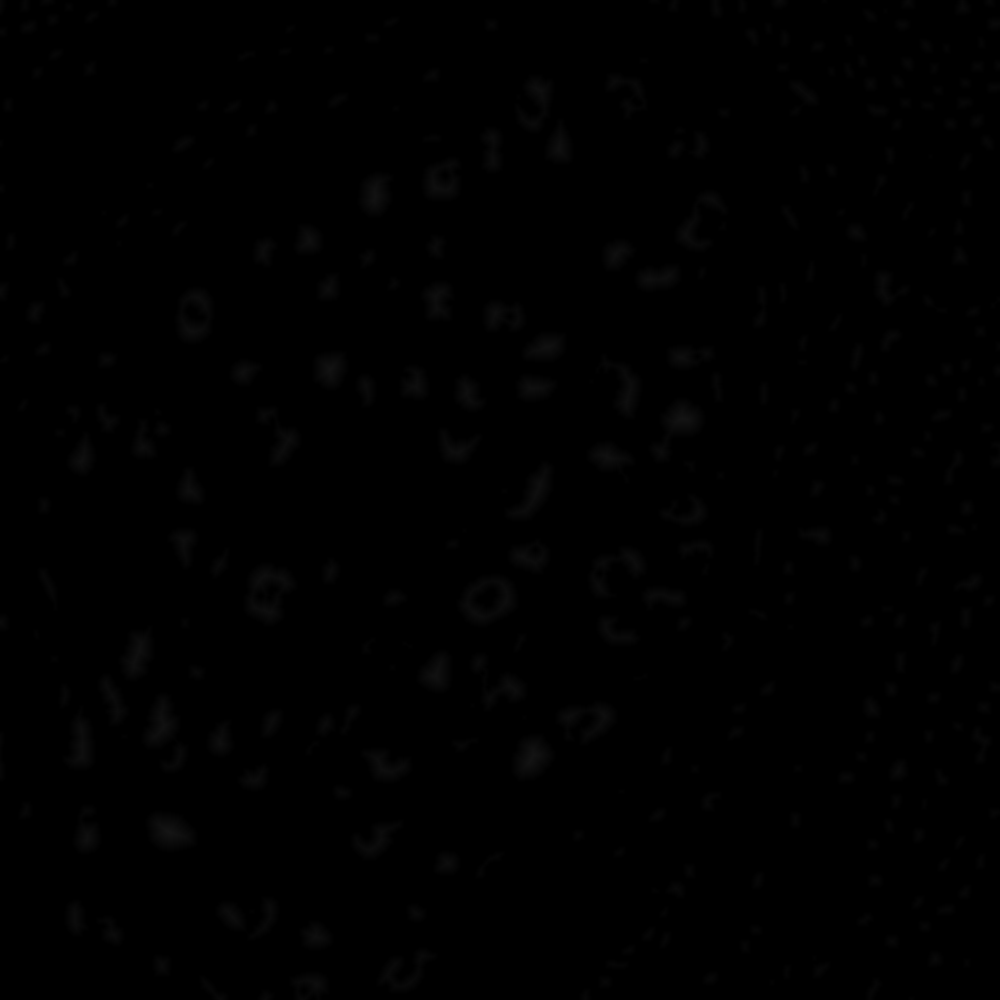

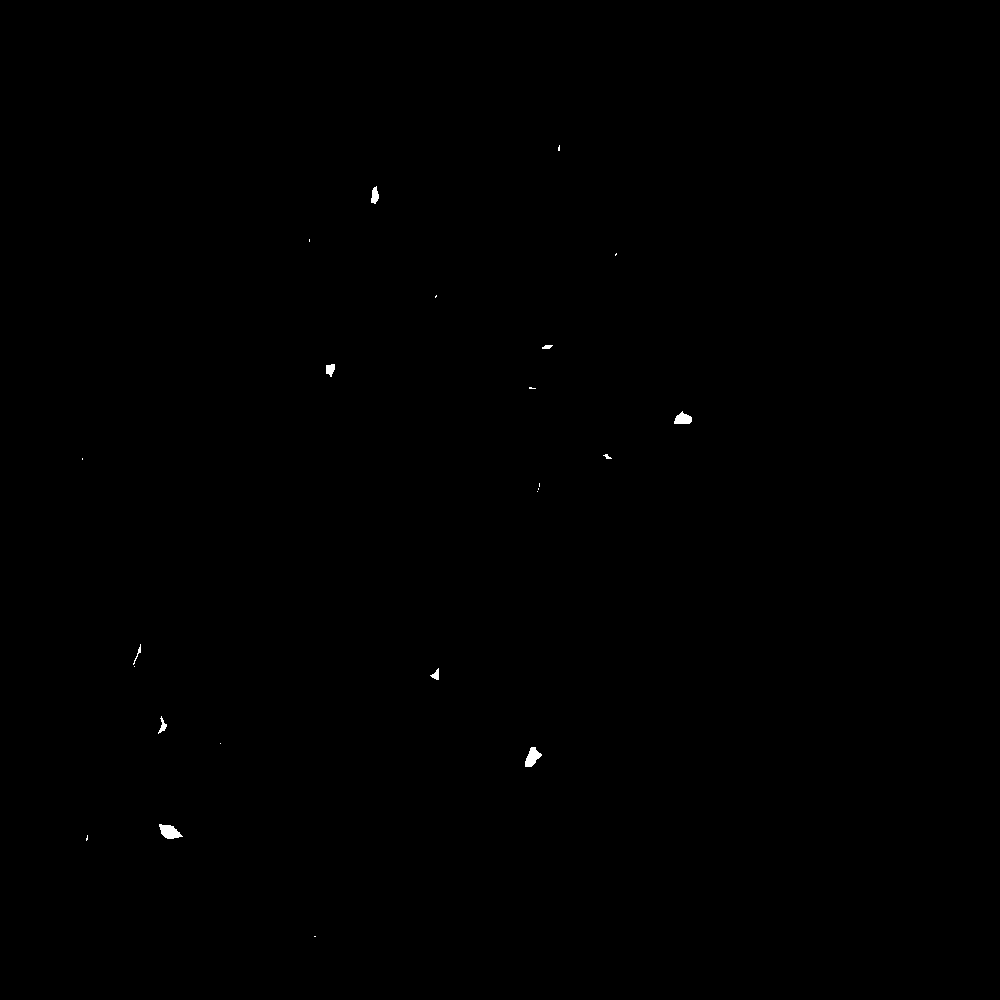

In [39]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=1)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

cv2_imshow(dist_transform)
cv2_imshow(sure_fg)

In [40]:
print(pred_mod_alias_np.shape)

img = np.zeros((1000, 1000, 3), dtype = np.uint8)
img[:,:,0] = pred_mod_alias_np
img[:,:,1] = pred_mod_alias_np
img[:,:,2] = pred_mod_alias_np

print(img.shape)

(1000, 1000)
(1000, 1000, 3)


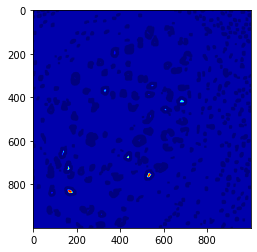

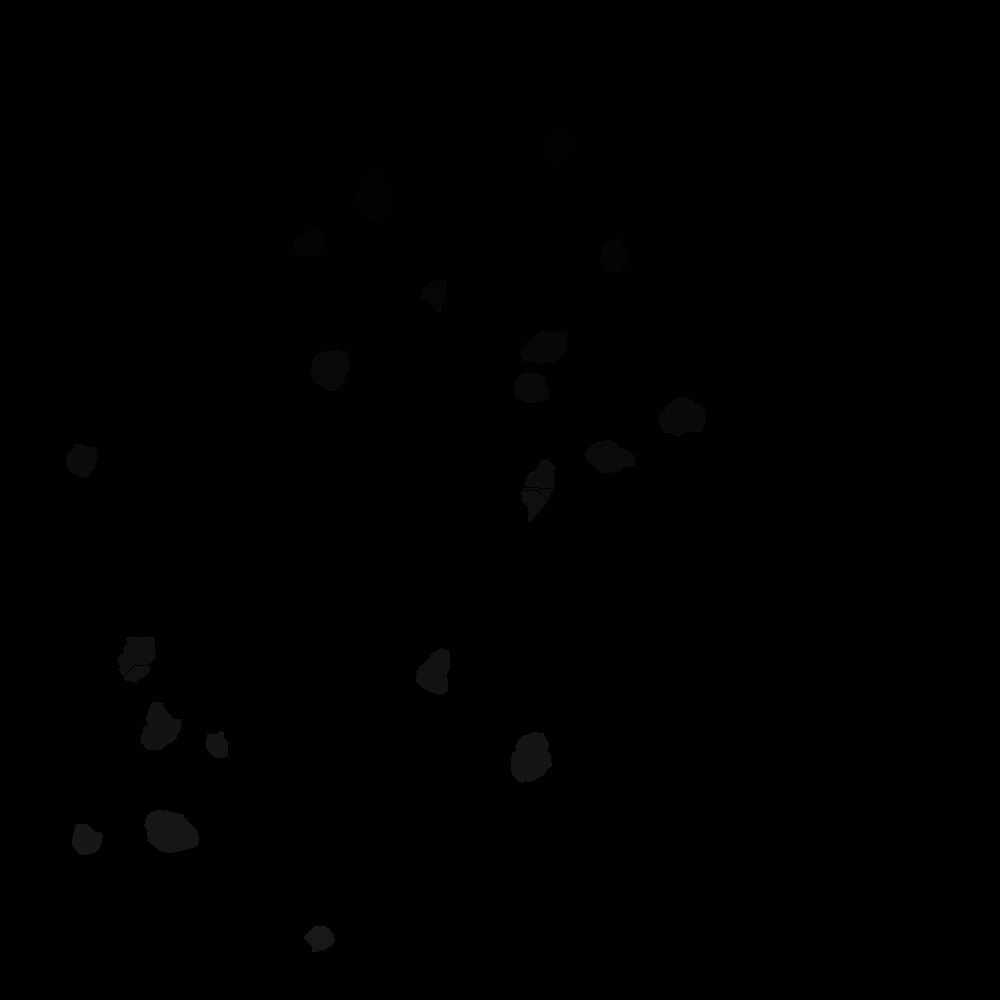

In [41]:
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers, cmap = 'jet')
plt.show()

markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

cv2_imshow(markers)

In [ ]:
pred_modified_np = np.array(TF.to_pil_image(pred_modified))

kernel = np.ones((2, 2), np.uint8)
pred_modified_np = cv2.erode(pred_modified_np, kernel, iterations = 1)
#pred_modified_np = cv2.dilate(pred_modified_np, kernel, iterations = 1)

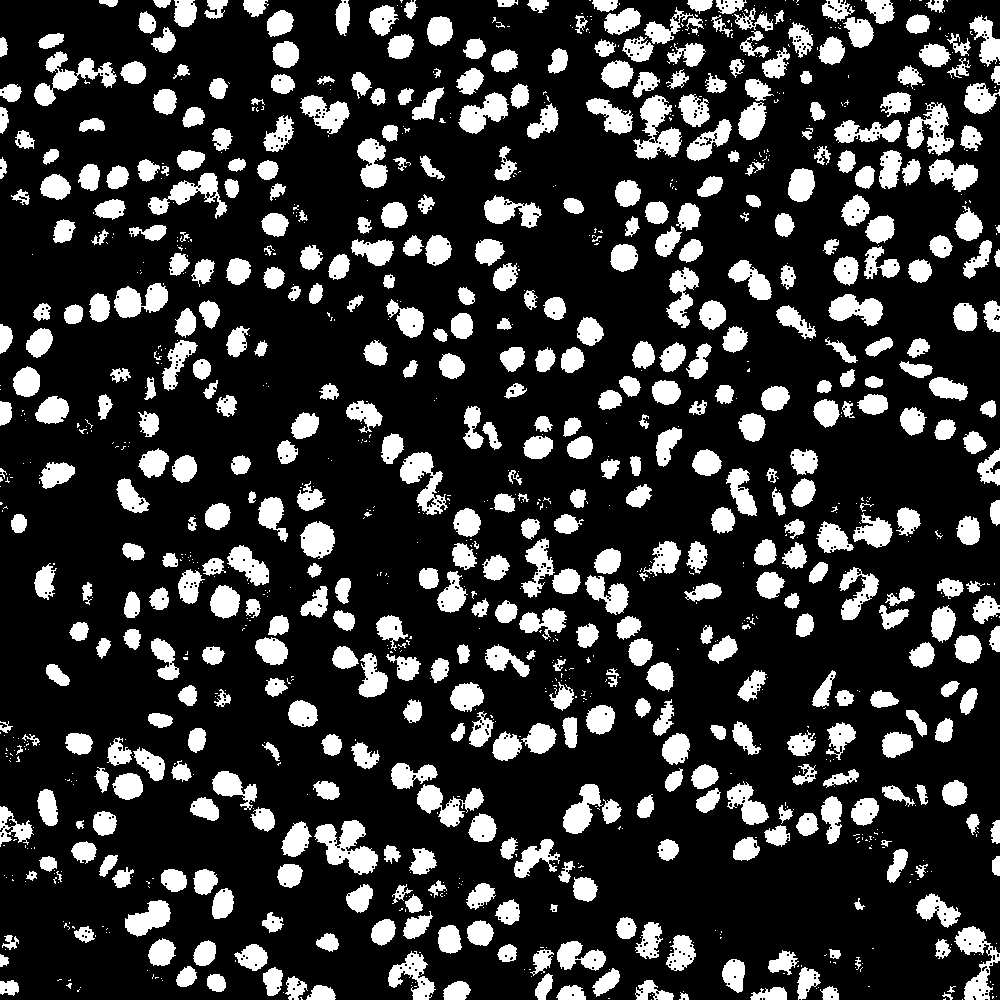

In [ ]:
cv2_imshow(pred_modified_np)

In [ ]:
pred_mod = TF.to_tensor(TF.to_pil_image(pred_modified_np))

pred_flat = pred_mod.view(-1)
true_flat = true_mask.view(-1)
score = jaccard_score(pred_flat, true_flat)
print(score)

0.6027825988994934


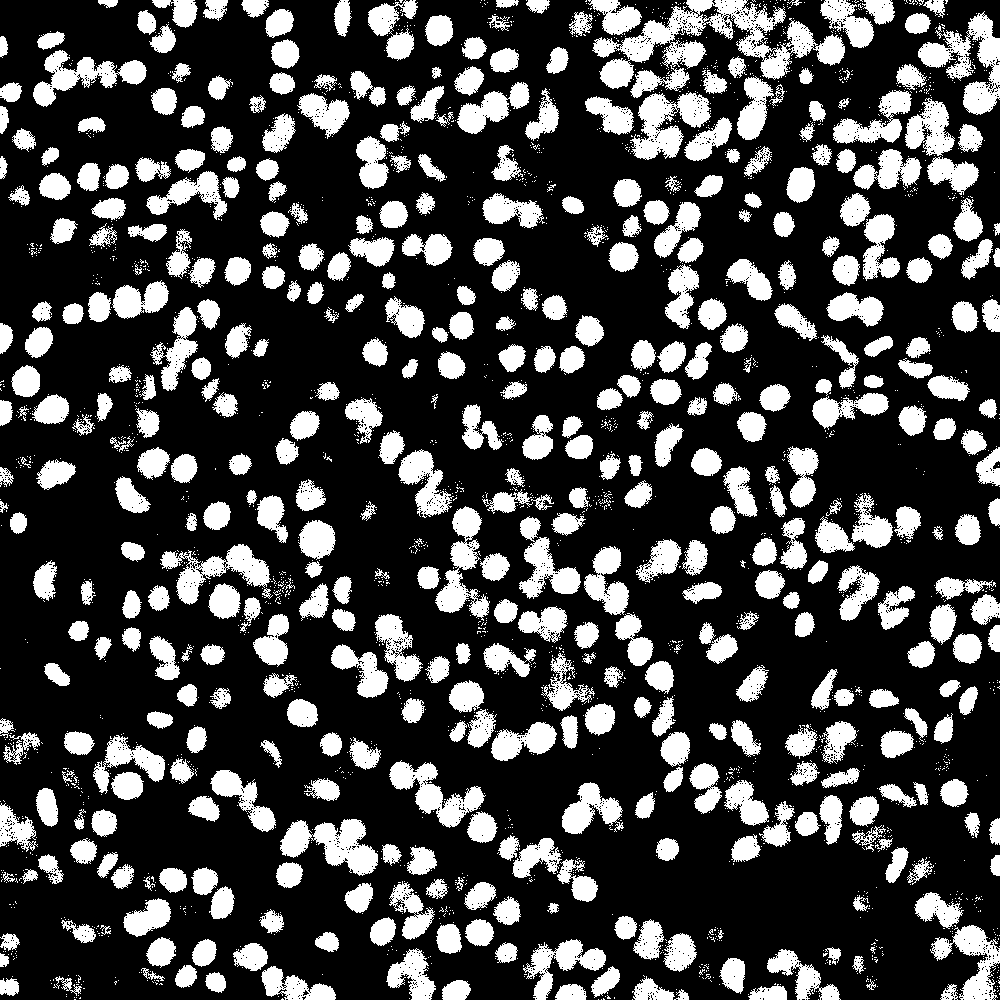

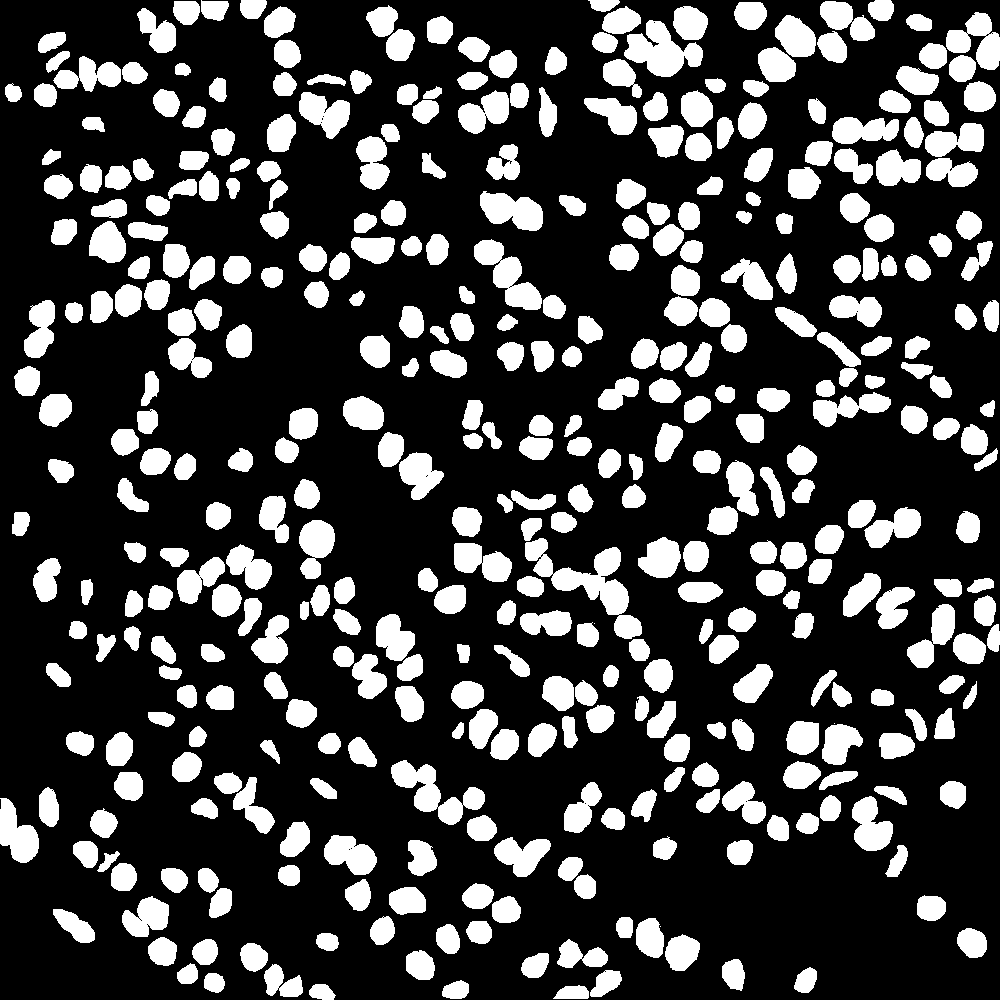

In [ ]:
from google.colab.patches import cv2_imshow

pred_np = np.array(TF.to_pil_image(pred_img))
true_np = np.array(TF.to_pil_image(true_mask))

params = cv2.SimpleBlobDetector_Params()

params.filterByCircularity = True
params.minCircularity = 0.8

detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(pred_np)

blank = np.zeros((1, 1))  
blobs = cv2.drawKeypoints(pred_np, keypoints, blank, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2_imshow(blobs) 
print(" ")
cv2_imshow(true_np)